In [55]:
import datasets
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import os

In [25]:
ds_uri = 's3://sagemaker-production-eu-central-1-kl-biometric-datasets/raw_datasets/face_biometrics/hackathon_2025-07_camera_fingerprint/'
ds_uri = './hf_ds'

In [26]:
%%time
ds = datasets.load_from_disk(ds_uri)
len(ds)

CPU times: user 88.2 ms, sys: 94.2 ms, total: 182 ms
Wall time: 122 ms


64823

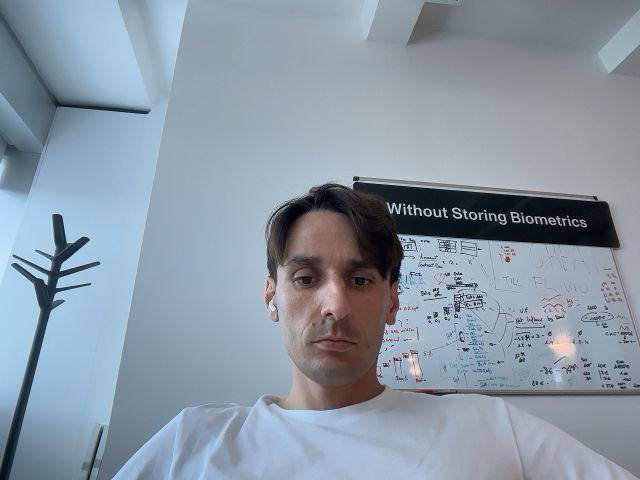

In [27]:
ds[0]["img_raw"]

In [28]:
%%time
df = ds.to_pandas()
print(df.shape)
df.head(3)

(64823, 65)
CPU times: user 788 ms, sys: 1.16 s, total: 1.95 s
Wall time: 1.92 s


,img_raw,photo_name,subject_name,session_folder,dataset_name,is_genuine_attempt,is_spoof,attack_type,datacollection_start_timestamp_s,attack_filename,...,browser_name,device_model,device_vendor,os_name,os_version,user_device_camera,split,img_w,img_h,img_wh
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,flavio@keyless.io_flavio@keyless.io-1751283476...,flavio@keyless.io,flavio@keyless.io_1751283476142_1.0.8,web_internal_dc_2025-06-12,True,False,genuine,1.751283e+09,None,...,Chrome,Macintosh,Apple,macOS,10.15.7,flavio@keyless.io___d785486b21be655650933327b9...,train,640,480,640x480
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,flavio@keyless.io_flavio@keyless.io-1751283476...,flavio@keyless.io,flavio@keyless.io_1751283476142_1.0.8,web_internal_dc_2025-06-12,True,False,genuine,1.751283e+09,None,...,Chrome,Macintosh,Apple,macOS,10.15.7,flavio@keyless.io___d785486b21be655650933327b9...,train,640,480,640x480
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,flavio@keyless.io_flavio@keyless.io-1751283476...,flavio@keyless.io,flavio@keyless.io_1751283476142_1.0.8,web_internal_dc_2025-06-12,True,False,genuine,1.751283e+09,None,...,Chrome,Macintosh,Apple,macOS,10.15.7,flavio@keyless.io___d785486b21be655650933327b9...,train,640,480,640x480


In [29]:
important_columns = [
    'subject_name', 'session_folder', 'photo_name', # user / session / frame ids
    'gif_link', 'file_timestamp_within_session_ms', 'frame_number', # frame info
    'device_metadata', # json string with all the device metadata info
    'camera_device_id', 'camera_label', 'user_device_camera', # camera info parsed from device metadata
    'split', # test / train split
    'os_name', 'os_version', # os info
    'img_w', 'img_h', 'img_wh', # img info
    'img_raw', # jpg bytes of image

]

df[important_columns]

,subject_name,session_folder,photo_name,gif_link,file_timestamp_within_session_ms,frame_number,device_metadata,camera_device_id,camera_label,user_device_camera,split,os_name,os_version,img_w,img_h,img_wh
0,flavio@keyless.io,flavio@keyless.io_1751283476142_1.0.8,flavio@keyless.io_flavio@keyless.io-1751283476...,https://storage.cloud.google.com/kl-cloud-func...,0.0,0.0,"{""media"": {""track"": {""capabilities"": {""aspectR...",d785486b21be655650933327b9b5295bcfa607f7a879d5...,MacBook Air Camera (0000:0001),flavio@keyless.io___d785486b21be655650933327b9...,train,macOS,10.15.7,640,480,640x480
1,flavio@keyless.io,flavio@keyless.io_1751283476142_1.0.8,flavio@keyless.io_flavio@keyless.io-1751283476...,https://storage.cloud.google.com/kl-cloud-func...,299.0,6.0,"{""media"": {""track"": {""capabilities"": {""aspectR...",d785486b21be655650933327b9b5295bcfa607f7a879d5...,MacBook Air Camera (0000:0001),flavio@keyless.io___d785486b21be655650933327b9...,train,macOS,10.15.7,640,480,640x480
2,flavio@keyless.io,flavio@keyless.io_1751283476142_1.0.8,flavio@keyless.io_flavio@keyless.io-1751283476...,https://storage.cloud.google.com/kl-cloud-func...,599.0,12.0,"{""media"": {""track"": {""capabilities"": {""aspectR...",d785486b21be655650933327b9b5295bcfa607f7a879d5...,MacBook Air Camera (0000:0001),flavio@keyless.io___d785486b21be655650933327b9...,train,macOS,10.15.7,640,480,640x480
3,flavio@keyless.io,flavio@keyless.io_1751283476142_1.0.8,flavio@keyless.io_flavio@keyless.io-1751283476...,https://storage.cloud.google.com/kl-cloud-func...,899.0,18.0,"{""media"": {""track"": {""capabilities"": {""aspectR...",d785486b21be655650933327b9b5295bcfa607f7a879d5...,MacBook Air Camera (0000:0001),flavio@keyless.io___d785486b21be655650933327b9...,train,macOS,10.15.7,640,480,640x480
4,flavio@keyless.io,flavio@keyless.io_1751283476142_1.0.8,flavio@keyless.io_flavio@keyless.io-1751283476...,https://storage.cloud.google.com/kl-cloud-func...,1149.0,23.0,"{""media"": {""track"": {""capabilities"": {""aspectR...",d785486b21be655650933327b9b5295bcfa607f7a879d5...,MacBook Air Camera (0000:0001),flavio@keyless.io___d785486b21be655650933327b9...,train,macOS,10.15.7,640,480,640x480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64818,antonio.epifani@keyless.io,antonio.epifani@keyless.io_1751372521985_1.0.8,antonio.epifani@keyless.io_antonio.epifani@key...,https://storage.cloud.google.com/kl-cloud-func...,8800.0,175.0,"{""media"": {""track"": {""capabilities"": {""aspectR...",1BA7B61A89880176866F8533D603036EB3252C12,Fotocamera anteriore,antonio.epifani@keyless.io___1BA7B61A898801768...,train,iOS,18.5,640,640,640x640
64819,antonio.epifani@keyless.io,antonio.epifani@keyless.io_1751372521985_1.0.8,antonio.epifani@keyless.io_antonio.epifani@key...,https://storage.cloud.google.com/kl-cloud-func...,9052.0,180.0,"{""media"": {""track"": {""capabilities"": {""aspectR...",1BA7B61A89880176866F8533D603036EB3252C12,Fotocamera anteriore,antonio.epifani@keyless.io___1BA7B61A898801768...,train,iOS,18.5,640,640,640x640
64820,antonio.epifani@keyless.io,antonio.epifani@keyless.io_1751372521985_1.0.8,antonio.epifani@keyless.io_antonio.epifani@key...,https://storage.cloud.google.com/kl-cloud-func...,9303.0,185.0,"{""media"": {""track"": {""capabilities"": {""aspectR...",1BA7B61A89880176866F8533D603036EB3252C12,Fotocamera anteriore,antonio.epifani@keyless.io___1BA7B61A898801768...,train,iOS,18.5,640,640,640x640
64821,antonio.epifani@keyless.io,antonio.epifani@keyless.io_1751372521985_1.0.8,antonio.epifani@keyless.io_antonio.epifani@key...,https://storage.cloud.google.com/kl-cloud-func...,9555.0,190.0,"{""media"": {""track"": {""capabilities"": {""aspectR...",1BA7B61A89880176866F8533D603036EB3252C12,Fotocamera anteriore,antonio.epifani@keyless.io___1BA7B61A898801768...,train,iOS,18.5,640,640,640x640


## Splitted to train/test

In [30]:
df.split.value_counts(dropna=False)

split
train    54143
test     10680
Name: count, dtype: int64

In [78]:
for s in df.split.unique():
    print(f'split=="{s}" users: {set(df[df.split == s].subject_name)}')

split=="train" users: {'jovana.blagojeviv@keyless.io', 'marco.albarelli@keyless.io', 'salvataore@keyless.io', 'primiano.medugno@keyless.io', 'jacopo.bartolini@keyless.io', 'antonio.epifani@keyless.io', 'iryna.kozoriz@keyless.io', 'fabian@keyless.io', 'tobin.broadfoot@keyless.io', 'mario.digirolamo@keyless.io', 'william.dias@keyless.io', 'davide@keyless.io', 'max@keyless.io', 'alex.jones@keyless.io', 'salvatore@keyless.io', 'daniele@keyless.io', 'michele@keyless.io', 'francesca.mavilio@keyless.io', 'alain.carlucci@keyless.io', 'mathias.hoellerl@keyless.io', 'jovana.blagojevic@keyless.io', 'andrea.morandotti@keyless.io', 'michelangelo.fiore@keyless.io', '0000', 'zac@keyless.io', 'michele.donzelli@keyless.io', 'igor.danylyshyn@keyless.io', 'alessandro.dangeli@keyless.io', 'domenico.urzi@keyless.io', 'dpanic', 'paolo@keyless.io', 'mathias@keyless.io', 'dalibor.panic@keyless.io', 'francesco@keyless.io', 'cecilia.martinez@keyless.io', 'mattia.vighesso@keyless.io', 'satish.karry@keyless.io', 

#### Split is done per user:

In [77]:
test_df = df[df.split == 'test']
print(f'test: {test_df.shape}, sessions: {test_df.session_folder.nunique()}, users: {test_df.subject_name.nunique()}')
train_df = df[df.split == 'train']
print(f'train: {train_df.shape}, sessions: {train_df.session_folder.nunique()}, users: {train_df.subject_name.nunique()}')

assert len(set(test_df.subject_name) & set(train_df.subject_name)) == 0

test: (10680, 65), sessions: 279, users: 6
train: (54143, 65), sessions: 1611, users: 46


## Most efficient way how to get session

CPU times: user 28.2 ms, sys: 19 μs, total: 28.3 ms
Wall time: 27.3 ms


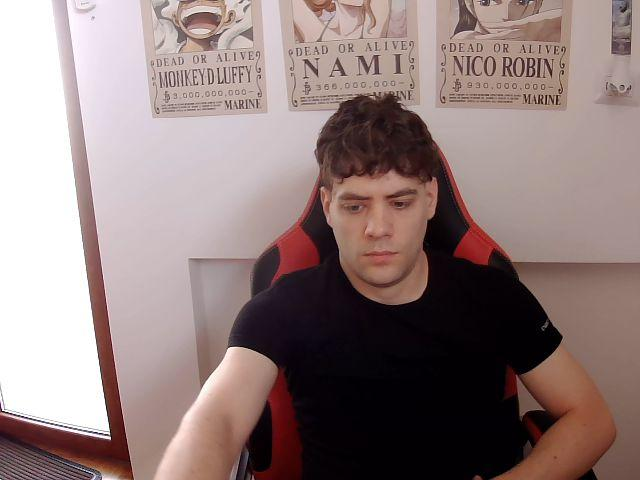

In [72]:
%%time
selected_session_folder = df.iloc[100].session_folder
idx_from_df = df[df.session_folder == selected_session_folder].index.tolist()
sess_ds = ds.select(idx_from_df)
sess_ds[0]['img_raw']

## Calculate scores matrix

In [73]:
def calculate_scores():
    rows = []
    for sess_enroll, enrl_df in tqdm(test_df.groupby('session_folder')):
        for sess_auth, auth_df in test_df.groupby('session_folder'):

            sim_score = np.random.rand() # this is your score for session similarity between sess_enroll vs sess_auth
            # if your method is symmetrics (ie enroll <> auth is the same as auth <> enroll), please cache the results, as this is looping through everything

            enrl_row = enrl_df.iloc[0]
            auth_row = auth_df.iloc[0]

            rows.append({
                'enroll_sess': sess_enroll,
                'auth_sess': sess_auth,

                'enroll_user': enrl_row.subject_name,
                'enroll_camera_label': enrl_row.camera_label,
                'enroll_user_device_camera': enrl_row.user_device_camera,

                'auth_user': auth_row.subject_name,
                'auth_camera_label': auth_row.camera_label,
                'auth_user_device_camera': auth_row.user_device_camera,

                'is_same_user': enrl_row.subject_name == auth_row.subject_name,
                'is_same_camera_label': enrl_row.camera_label == auth_row.camera_label,
                'is_same_user_device_camera': enrl_row.user_device_camera == auth_row.user_device_camera,

                'similarity': sim_score, # This is your score
            })

    return rows

pred_df = pd.DataFrame(calculate_scores())
pred_df.head(3)



  0%|          | 0/279 [00:00<?, ?it/s]

,enroll_sess,auth_sess,enroll_user,enroll_camera_label,enroll_user_device_camera,auth_user,auth_camera_label,auth_user_device_camera,is_same_user,is_same_camera_label,is_same_user_device_camera,similarity
0,ahmed.atef@keyless.io_1750871273156_1.0.8,ahmed.atef@keyless.io_1750871273156_1.0.8,ahmed.atef@keyless.io,Camo,ahmed.atef@keyless.io___79a3a0040ddba27de980b1...,ahmed.atef@keyless.io,Camo,ahmed.atef@keyless.io___79a3a0040ddba27de980b1...,True,True,True,0.249581
1,ahmed.atef@keyless.io_1750871273156_1.0.8,ahmed.atef@keyless.io_1750871501815_1.0.8,ahmed.atef@keyless.io,Camo,ahmed.atef@keyless.io___79a3a0040ddba27de980b1...,ahmed.atef@keyless.io,Camo,ahmed.atef@keyless.io___79a3a0040ddba27de980b1...,True,True,True,0.596320
2,ahmed.atef@keyless.io_1750871273156_1.0.8,ahmed.atef@keyless.io_1750871561316_1.0.8,ahmed.atef@keyless.io,Camo,ahmed.atef@keyless.io___79a3a0040ddba27de980b1...,ahmed.atef@keyless.io,Fantech Luminous C30 (1d6c:1278),ahmed.atef@keyless.io___01d1c987f5595b61ccf52e...,True,False,False,0.688832
